In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [3]:
key = jax.random.PRNGKey(0)

In [5]:
import mrfx
from mrfx.models import GMRF, GUM
from mrfx.samplers import SpectralSamplerGMRF, SpectralSamplerGUM

In [6]:
gmrf = GMRF(kappa=0.3)

/tmp/ipykernel_103221/1016386760.py:1: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=0.3)


In [7]:
spectral_sampler = SpectralSamplerGMRF(n_bands=10000, lx=256, ly=256)

In [8]:
key, subkey = jax.random.split(key, 2)
X = spectral_sampler.sample_image(gmrf, subkey)

In [9]:
X.shape

(256, 256)

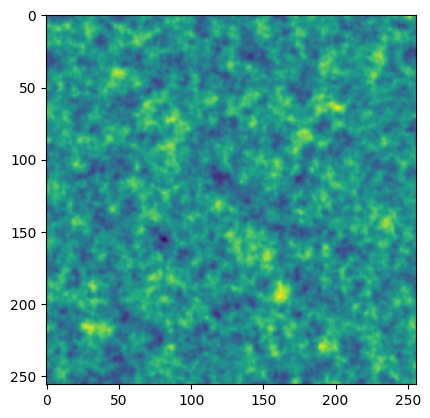

In [10]:
plt.imshow(X)
plt.show()

In [47]:
gum = GUM(kappa=0.05, K=4, dim=2)

In [48]:
gum_sampler = SpectralSamplerGUM(n_bands=1000, lx=256, ly=256)

In [49]:
key, subkey = jax.random.split(key, 2)
X = gum_sampler.sample_image(gum, subkey)

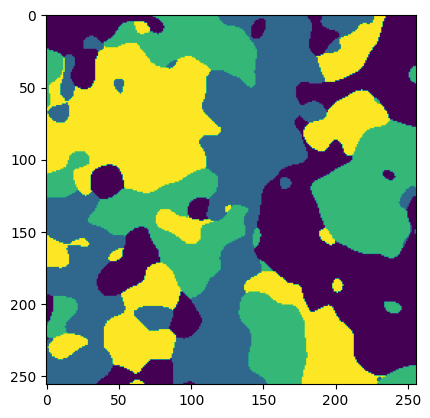

In [50]:
plt.imshow(X)
plt.show()

In [59]:
import numpy as np
import time
def time_update_one_image(
    Sampler,
    Model,
    key,
    Ks,
    sizes,
    reps,
    kwargs_sampler=None,
    kwargs_model=None,
) -> list:
    """
    Get a time estimate of the call to `update_one_image` for a given sampler
    and a given model

    Parameters
    ----------
    Sampler
        A non-instantiated AbstractGibbsSampler
    Model
        A non-instantiated AbstractMarkovRandomFieldModel
    key
        A jax PRNG key
    Ks
        A list, sequence, numpy array of the numbers of classes of the model
        that we want to time
    size
        An list, sequence, array of pairs of each (lx, ly), ie. the dimensions
        over which we want to time the sampler
    reps
        An integer. The number of time sample we average for a given
        combination of K and size
    kwargs_sampler
        A dictionary with the remaining arguments needed to instanciate the
        sampler (passed as keywords arguments): all the arguments apart from
        `lx` and `ly`
    kwargs_model
        A dictionary with the remaining arguments needed to instanciate the
        model (passed as keywords arguments): all the arguments apart from
        `K`

    Note that Ks must be a numpy array (because it is passed as a static_argnum
    in the jitted functions of mrfx and jax.numpy arrays are non hashable)
    """
    Ks = np.asarray(Ks)
    times = []
    for k in Ks:
        times.append([])
        model = Model(K=k, **kwargs_model)
        for lx, ly in sizes:
            sampler = Sampler(lx=lx, ly=ly, **kwargs_sampler)

            rep_times = []
            print(f"Rep ( / {reps}), ", end="")
            key, subkey = jax.random.split(key, 2)

            # compilation
            start = time.time()
            j_sample_image = jax.jit(sampler.sample_image)
            X = j_sample_image(model=model, key=key)
            X.block_until_ready()
            end = time.time()
            compilation_time = end - start

            for r in range(reps):
                key, subkey = jax.random.split(key, 2)

                start = time.time()
                X = j_sample_image(model=model, key=key)
                X.block_until_ready()
                end = time.time()
                runtime = end - start

                rep_times.append(runtime)
                print(f"{r+1} ", end="")
            runtime_mean = np.mean(rep_times)
            print(f"\n{k=}, {lx=}, {ly=}, {compilation_time=}, {runtime_mean=}")

            times[-1].append(runtime_mean)
    return times

In [66]:
key, subkey = jax.random.split(key, 2)
Ks = jnp.arange(2, 11)
sizes = [(2 ** e, 2 ** e) for e in range(4, 9)]
times = time_update_one_image(
    Sampler=SpectralSamplerGUM,
    Model=GUM,
    key=subkey,
    Ks=Ks,
    sizes=sizes,
    reps=10,
    kwargs_sampler={"n_bands":1000},
    kwargs_model={"kappa":0.05, "dim":2},
) 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


Rep ( / 10), 1 2 3 4 5 6 7 8 9 10 
k=2, lx=16, ly=16, compilation_time=0.4311997890472412, runtime_mean=0.007821226119995117
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=2, lx=32, ly=32, compilation_time=0.44933390617370605, runtime_mean=0.01245417594909668
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=2, lx=64, ly=64, compilation_time=0.40749025344848633, runtime_mean=0.03331477642059326
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=2, lx=128, ly=128, compilation_time=0.4637563228607178, runtime_mean=0.11260044574737549
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=2, lx=256, ly=256, compilation_time=0.8627791404724121, runtime_mean=0.39678494930267333
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=3, lx=16, ly=16, compilation_time=0.6640584468841553, runtime_mean=0.013118290901184082
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=3, lx=32, ly=32, compilation_time=0.611703634262085, runtime_mean=0.01686067581176758
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=3, lx=64, ly=64, compilation_time=0.9005401134490967, runtime_mean=0.07906599044799804
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=3, lx=128, ly=128, compilation_time=0.973031759262085, runtime_mean=0.1923522710800171
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=3, lx=256, ly=256, compilation_time=1.4522199630737305, runtime_mean=0.6753895521163941
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=4, lx=16, ly=16, compilation_time=1.0931074619293213, runtime_mean=0.014099717140197754
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=4, lx=32, ly=32, compilation_time=1.151968002319336, runtime_mean=0.03996853828430176
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=4, lx=64, ly=64, compilation_time=1.2308402061462402, runtime_mean=0.1452770233154297
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=4, lx=128, ly=128, compilation_time=1.4471426010131836, runtime_mean=0.3001092910766602
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=4, lx=256, ly=256, compilation_time=1.7724676132202148, runtime_mean=0.9470031023025512
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=5, lx=16, ly=16, compilation_time=1.3348803520202637, runtime_mean=0.022027087211608887
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=5, lx=32, ly=32, compilation_time=1.0796842575073242, runtime_mean=0.06794552803039551
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=5, lx=64, ly=64, compilation_time=1.250182867050171, runtime_mean=0.1569307565689087
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=5, lx=128, ly=128, compilation_time=1.4262893199920654, runtime_mean=0.36245968341827395
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=5, lx=256, ly=256, compilation_time=2.2609734535217285, runtime_mean=1.2438573360443115
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=6, lx=16, ly=16, compilation_time=1.2503905296325684, runtime_mean=0.0284015417098999
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=6, lx=32, ly=32, compilation_time=1.240936279296875, runtime_mean=0.07319302558898926
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=6, lx=64, ly=64, compilation_time=1.3854897022247314, runtime_mean=0.20578489303588868
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=6, lx=128, ly=128, compilation_time=1.701620101928711, runtime_mean=0.4640920639038086
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=6, lx=256, ly=256, compilation_time=2.829972743988037, runtime_mean=1.520269513130188
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=7, lx=16, ly=16, compilation_time=1.4955310821533203, runtime_mean=0.04384782314300537
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=7, lx=32, ly=32, compilation_time=1.6074912548065186, runtime_mean=0.0773688554763794
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=7, lx=64, ly=64, compilation_time=1.7127983570098877, runtime_mean=0.2471548795700073
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=7, lx=128, ly=128, compilation_time=2.189842462539673, runtime_mean=0.5530843257904052
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=7, lx=256, ly=256, compilation_time=3.183809280395508, runtime_mean=1.832573652267456
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=8, lx=16, ly=16, compilation_time=1.7442498207092285, runtime_mean=0.03736770153045654
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=8, lx=32, ly=32, compilation_time=1.8010880947113037, runtime_mean=0.09655194282531739
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=8, lx=64, ly=64, compilation_time=1.9803693294525146, runtime_mean=0.29386887550354
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=8, lx=128, ly=128, compilation_time=2.405503511428833, runtime_mean=0.6471966743469239
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=8, lx=256, ly=256, compilation_time=3.749525547027588, runtime_mean=2.081135940551758
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=9, lx=16, ly=16, compilation_time=1.9660918712615967, runtime_mean=0.05145738124847412
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=9, lx=32, ly=32, compilation_time=2.2042996883392334, runtime_mean=0.11566994190216065
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=9, lx=64, ly=64, compilation_time=2.950103759765625, runtime_mean=0.31943259239196775
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=9, lx=128, ly=128, compilation_time=2.6330294609069824, runtime_mean=0.7237804889678955
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=9, lx=256, ly=256, compilation_time=4.3247599601745605, runtime_mean=2.394174885749817
Rep ( / 10), 

/tmp/ipykernel_103221/2124145309.py:50: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = Model(K=k, **kwargs_model)
/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=10, lx=16, ly=16, compilation_time=2.2949893474578857, runtime_mean=0.05263297557830811
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=10, lx=32, ly=32, compilation_time=3.2697176933288574, runtime_mean=0.11513168811798095
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=10, lx=64, ly=64, compilation_time=3.4697210788726807, runtime_mean=0.35457587242126465
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=10, lx=128, ly=128, compilation_time=4.023025751113892, runtime_mean=0.8110408544540405
Rep ( / 10), 

/home/hugo/Documents/recherche/gum/code/mrfx_private/mrfx/samplers/_spectral.py:79: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  gmrf = GMRF(kappa=model.kappa, dim=2) # dim is fixed since we want to


1 2 3 4 5 6 7 8 9 10 
k=10, lx=256, ly=256, compilation_time=6.004391670227051, runtime_mean=2.687701964378357


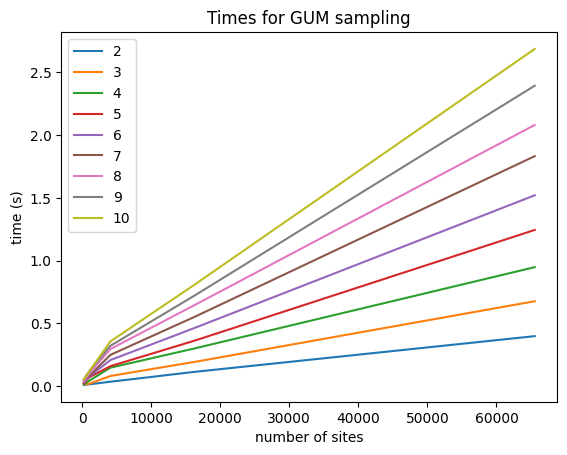

In [67]:
from mrfx.experiments import plot_benchmark
plot_benchmark(Ks, sizes, times, title="Times for GUM sampling")